In [1]:
from os import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Bionic AI/')
from functions import *
import pickle

In [2]:
subjects_test, events_test = getSubjectsData(Test=True)

## Extract the First Trial from A Subjects Test Data


In [3]:
# batch

## Get Batches for the CNN
def getBatchV2(test_data,test_events):  
  num_features = 32 # number of electrodes
  window_size = 512 # window size (number of previous timesteps we want to consider when making predictions)
  # here we are predicting for trial 1 in this series
  num_samples = 3400 - 1000
 # much smaller dataset so dont have to make the 16 step jump between single batches
  indexes = np.arange(1000, 3400)

  X = np.zeros((num_samples, num_features, window_size//2))
    
  b = 0
  for i in indexes:
    start = i - window_size if i - window_size > 0 else 0    
    tmp = test_data.iloc[start:i,:]
    X[b,:,:] = tmp[::2].transpose()
        
    b += 1
  y = test_events[test_events.index.isin(indexes)]
  y = y.to_numpy()

  return torch.DoubleTensor(X), torch.DoubleTensor(y) 

## Predict for This Trial

In [4]:
CNN = CNN().double()

In [5]:
CNN.load_state_dict(torch.load(f"/content/drive/My Drive/Colab Notebooks/Bionic AI/Scenario 3 Models/CNN/Subject1_Model"))

<All keys matched successfully>

In [6]:

CNN.eval()

p = []
tru = []

x_test, y_test = getBatchV2(subjects_test[0], events_test[0])
x_test = (x_test)

preds = CNN(x_test)
#preds = preds.squeeze(1)

p.append(np.array(preds.data))
tru.append(np.array(y_test.data))

preds = p[0]
for i in p[1:]:
    preds = np.vstack((preds,i))
  
test = tru[0]
for i in tru[1:]:
    test = np.vstack((test,i))

## A Loss Fucntion  and A Threshld Function for Estimating the Cut Off Threshold for Each Event in the Trial

In [8]:
def getLoss(x1true,x2true,x1pred,x2pred):
  return sum([abs(x1true-x1pred),abs(x2true-x2pred)])

In [9]:
def getBestThresh(preds,test):
  # threshold range
  threshold = list(np.arange(0,1,0.001))
  bestTh = {}
  events = [0,1,2,3,4,5]
  eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
  plt.style.use('dark_background')

  for event in events:  
    truMotion = np.where(test[:,event] == 1)[0]
    losses = {}
    for th in threshold:
      predMotion = np.where(preds[:,event] > th)[0]
      try:
        loss = getLoss(truMotion[0],truMotion[-1],predMotion[0],predMotion[-1])
        #overlap = len(set(truMotion) & set(predMotion))
        lenDiff = abs(len(truMotion) - len(predMotion))
        losses[th] = loss + lenDiff

      except IndexError:
        pass
    bestTh[event] = min(losses, key=losses.get)
  return bestTh

In [10]:
threshold = getBestThresh(preds,test)

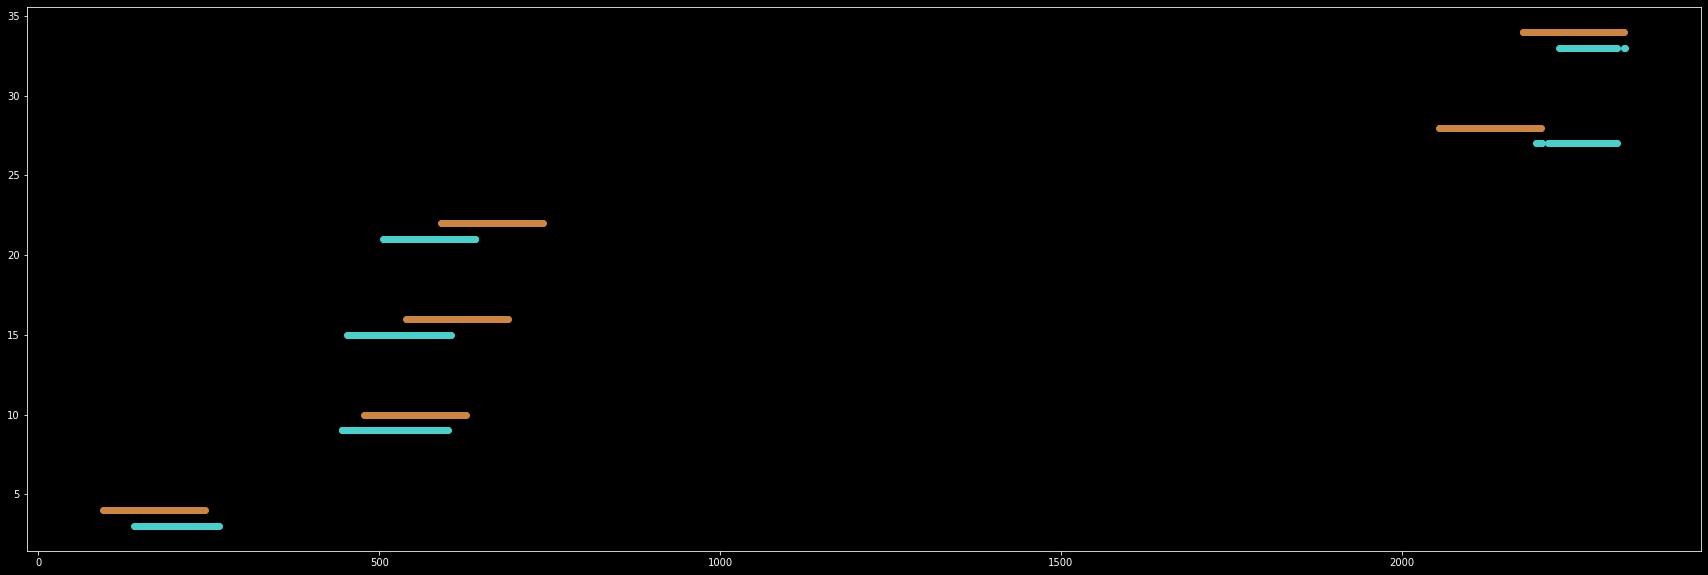

In [11]:
#threshold = getBestThresh(preds,test)
Threshold = getBestThresh(preds,test)
events = [0,1,2,3,4,5]
eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
plt.style.use('dark_background')
fig = plt.figure(figsize= [30,10])

count = 0
for i in range(len(events)):  
  truMotion = np.where(test[:,events[i]] == 1)
  predMotion = np.where(preds[:,events[i]] > threshold[i])
  count += 2
  #ax1 = fig.add_subplot(1,1,1)
  plt.scatter(predMotion[0], np.ones(len(predMotion[0]))+count,color='mediumturquoise')
  count += 2
  plt.scatter(truMotion[0], np.zeros(len(truMotion[0]))+count, color  = 'peru')
  count += 2
  #plt.set_title(eventNums[events[i]])

## Prepare the First Subplot: Truncating Electrode Data 


In [12]:
subjects, events = getSubjectsData(Test=False)

## Prepare the First Subplot:  Smoothing Electrode Data

In [13]:
firstTrial = subjects[0][:2400]

In [14]:
# smoothing Data
w = 25
k = 12

firstTrialSmooth = firstTrial.rolling(w).mean()
firstTrialSmooth = firstTrialSmooth.iloc[w-1:,:]
firstTrialShort = firstTrialSmooth.iloc[::k,:]

## Check the Smoothed Data 

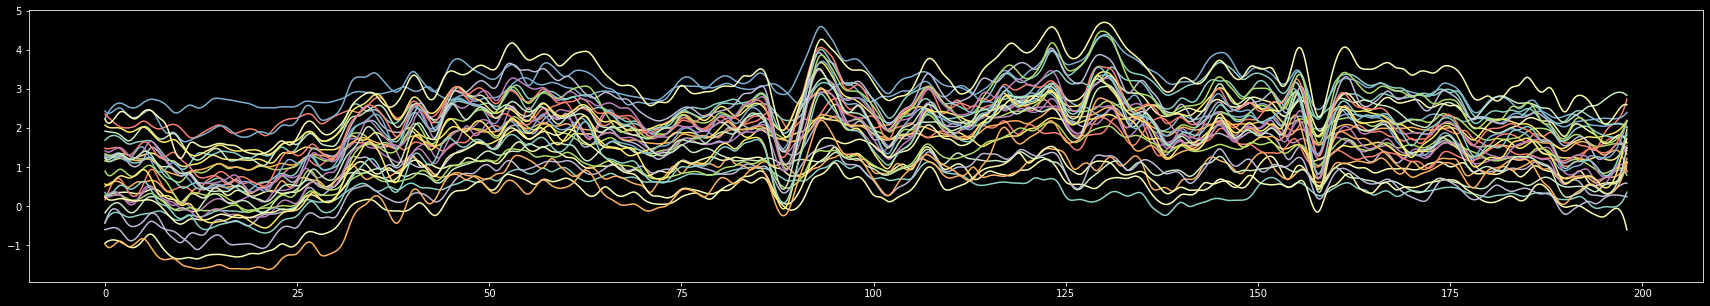

In [15]:
# Graph
fig = plt.figure(figsize= [30,5])
for col in range(32):
  
  #plt.plot(np.arange(len(firstTrialSmooth)),firstTrialSmooth.iloc[:,col])
  
  xnew = np.linspace(0, len(firstTrialShort), 2000) # 300 represents number of points to make between T.min and T.max

  spl = make_interp_spline(range(len(firstTrialShort)), firstTrialShort.iloc[:,col], k=3)  # type: BSpline
  power_smooth = spl(xnew)
  plt.plot(xnew, power_smooth)

## Prepare the Events Subplot: Data Truncating

In [16]:
testDf = pd.DataFrame(test)
predsDf = pd.DataFrame(preds)

tDf = testDf.iloc[w:,:]
tDf = tDf.iloc[::k,:]

pDf = predsDf.iloc[w:,:]
pDf = pDf.iloc[::k,:]

## Create a Static Graph for Animation

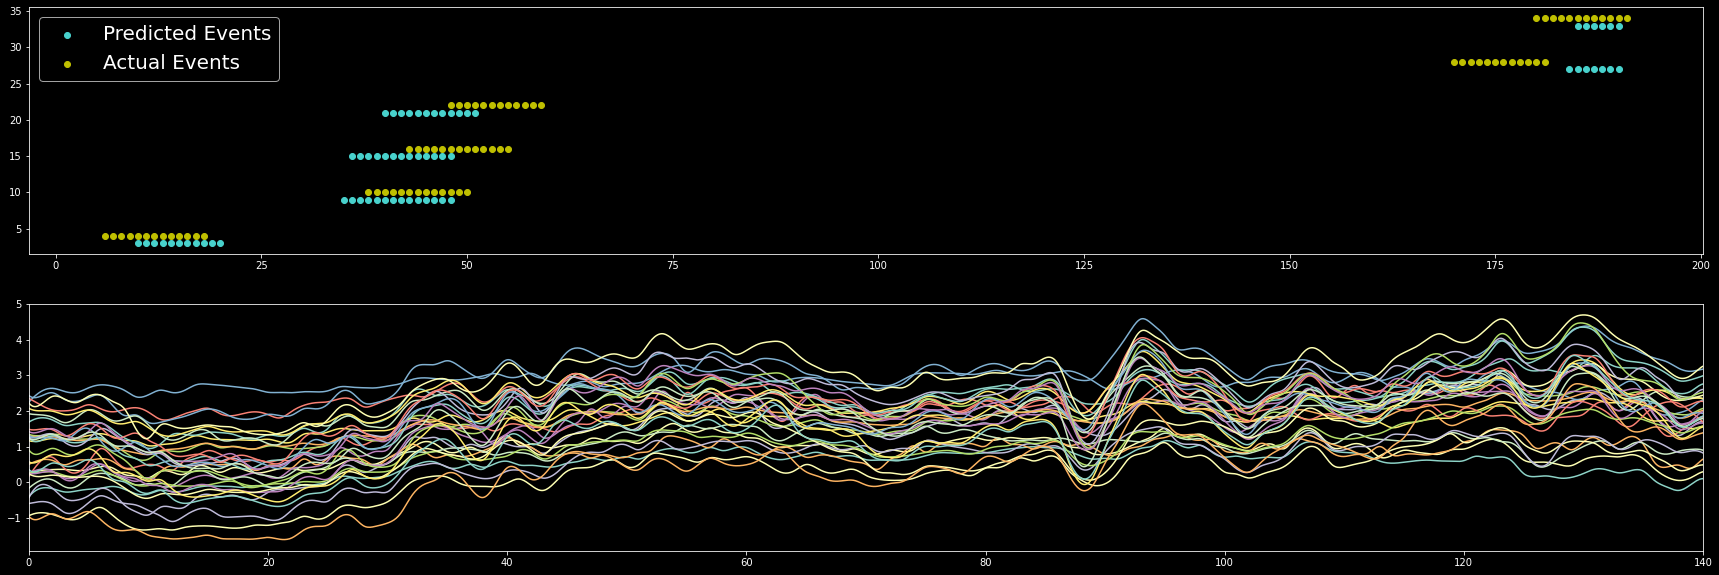

In [17]:
#threshold = getBestThresh(preds,test)
Threshold = getBestThresh(preds,test)
events = [0,1,2,3,4,5]
eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2,figsize = (30,10))


for col in range(32):
  
  
  xnew = np.linspace(0, len(firstTrialShort), 2000) 

  spl = make_interp_spline(range(len(firstTrialShort)), firstTrialShort.iloc[:,col], k=3)  
  power_smooth = spl(xnew)
  ax2.plot(xnew, power_smooth)
  ax2.set_xlim(0,140)

count = 0
for ev in events:  
  truMotion = np.where(tDf.iloc[:,ev] == 1)
  predMotion = np.where(pDf.iloc[:,ev] > threshold[ev])
  count += 2

  ax1.scatter(predMotion[0], np.ones(len(predMotion[0]))+count,color='mediumturquoise',label='Predicted Events')
  count += 2
  ax1.scatter(truMotion[0], np.zeros(len(truMotion[0]))+count, color  = 'y', label='Actual Events')
  count += 2
ax1.legend(['Predicted Events','Actual Events'],loc= 'upper left',fontsize=20)


## Final Animation

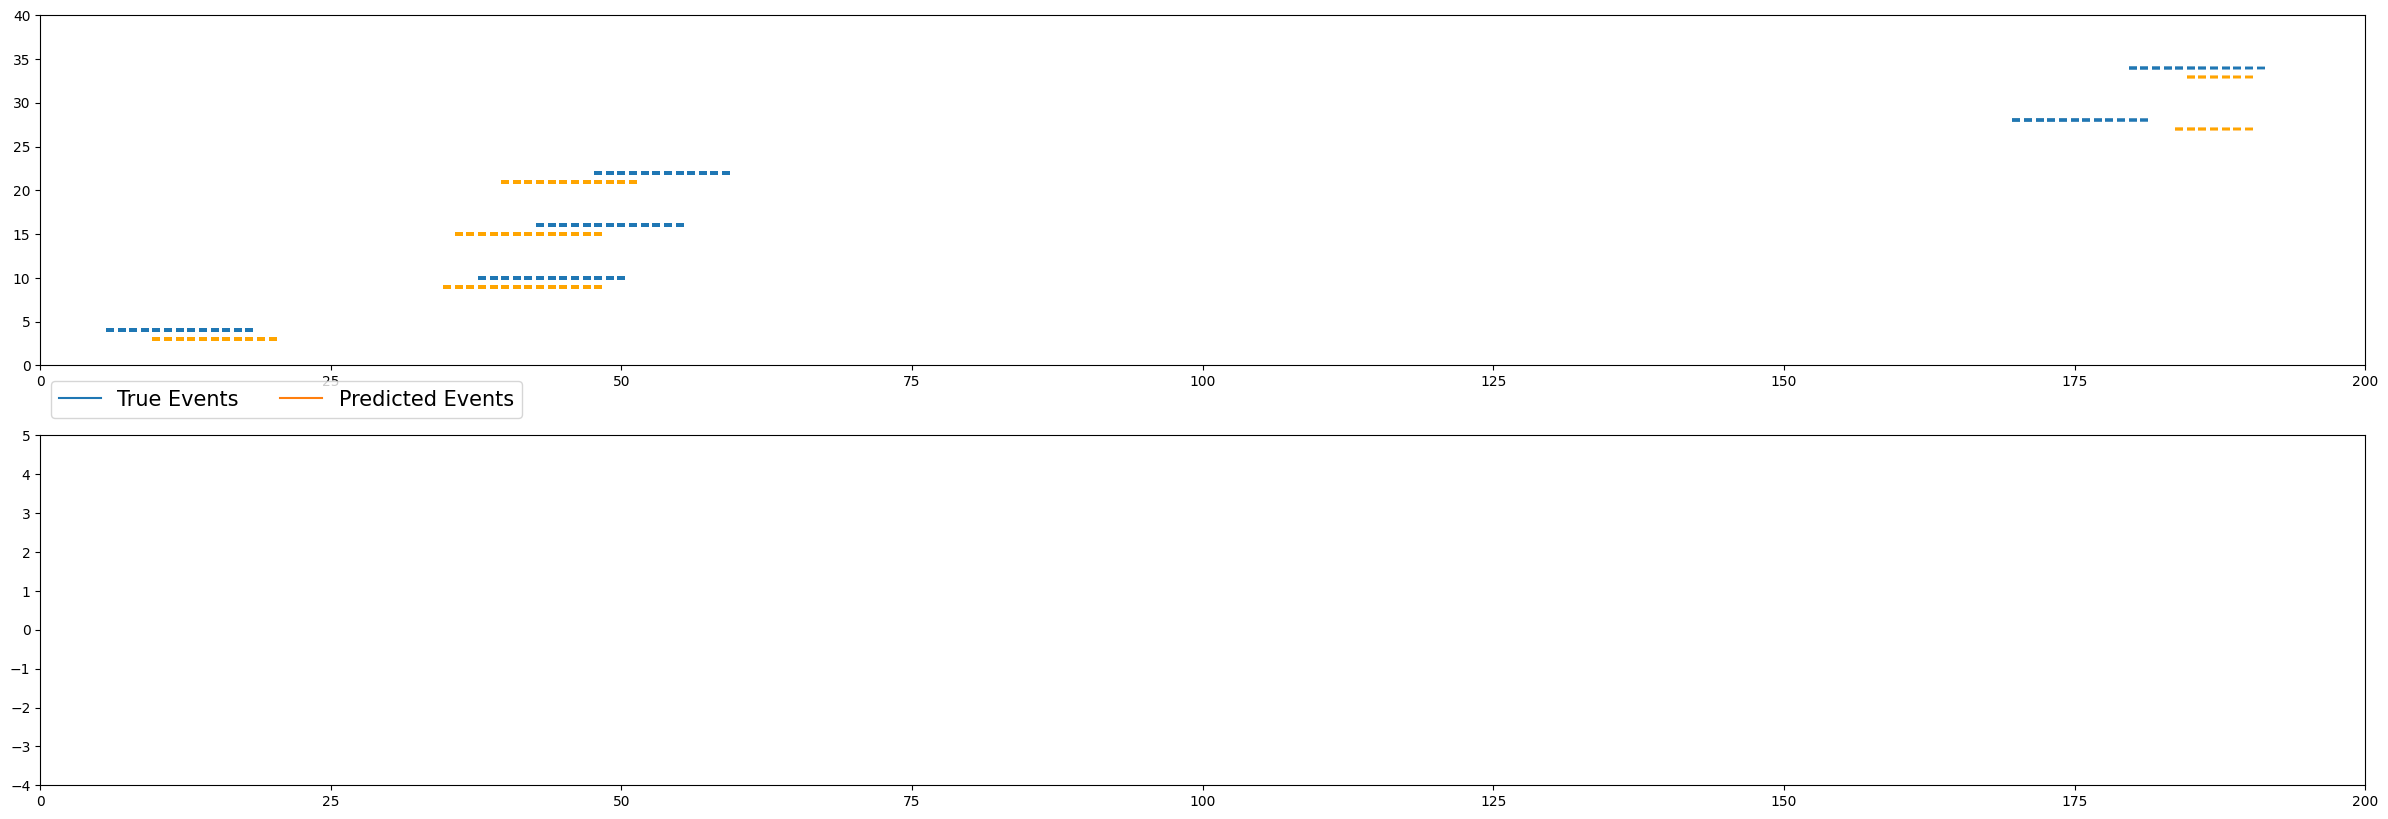

In [20]:
from matplotlib import animation


#threshold = getBestThresh(preds,test)
Threshold = getBestThresh(preds,test)
events = [0,1,2,3,4,5]
eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize = (30,10))

xnew = np.linspace(0, len(firstTrialShort), 300)

def animate(i):
  plt.cla()
  #ax2.set_xlim([1000, 3400]) # fix the x axis
  ax2.set_ylim([-4, 5]) # fix the y axis
  ax2.set_xlim(0,200)
  ax1.set_ylim(0,40)
  ax1.set_xlim(0,200)

  
  for col in range(32): 

    spl = make_interp_spline(range(len(firstTrialShort)), firstTrialShort.iloc[:,col], k=3)  
    power_smooth = spl(xnew)
    ax2.plot(xnew[:i], power_smooth[:i])
    

  count = 0
  for ev in events:  
    xtru= np.where(tDf.iloc[:,ev] == 1)[0]
    xpred = np.where(pDf.iloc[:,ev] > threshold[ev])[0] 
    count += 2

    ypred = np.ones(len(xpred)) + count
    for j in range(len(xpred)):
      if xnew[i] >= xpred[j]:
        ax1.scatter(xpred[j], ypred[j], color='orange', label='Predicted Events', marker='_',linewidths=150)
    count += 2
    
    ytru = np.zeros(len(xtru)) + count
    for j in range(len(xtru)):
      if xnew[i] >= xtru[j]:
        ax1.scatter(xtru[j], ytru[j], color='tab:blue', label='True Events', marker='_',linewidths=150)
    count += 2

    

  plt.legend(['True Events','Predicted Events'], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2,fontsize=15)
  #ax1.legend(labels)
  

anim = animation.FuncAnimation(fig, animate,frames = len(xnew+1), blit = False)
mywriter = animation.FFMpegWriter(fps=12)
anim.save('/content/drive/My Drive/Colab Notebooks/Bionic AI/lastModelMarker2.mp4', writer=mywriter)